In [1]:

import os
import pandas as pd
import cv2
import time
from glob import glob
from tqdm import tqdm
import numpy as np 
import cv2 as cv
import zipfile
import io
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from sklearn.impute import SimpleImputer
import albumentations
from sklearn.model_selection import train_test_split
from scipy.ndimage.morphology import binary_dilation
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from pathlib import Path

from PIL import Image

# You can use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')



/home/mp/viscode-github/DLFromScratch/.venv/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/tmp/ipykernel_8184/131638261.py:21: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_dilation


# Load dataset and deal with missing values

In [2]:
path_data_dir = Path('/home/mp/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2/kaggle_3m')
data_dir = glob(f'{path_data_dir}/*/*[0-9].tif')

In [3]:
csv_path = str(path_data_dir / 'data.csv')
df = pd.read_csv(csv_path)

missing_values_count = df.isnull().sum()
missing_values_count

Patient                       0
RNASeqCluster                18
MethylationCluster            1
miRNACluster                  0
CNCluster                     2
RPPACluster                  12
OncosignCluster               5
COCCluster                    0
histological_type             1
neoplasm_histologic_grade     1
tumor_tissue_site             1
laterality                    1
tumor_location                1
gender                        1
age_at_initial_pathologic     1
race                          2
ethnicity                     8
death01                       1
dtype: int64

In [4]:
# a SimpleImputer to fill missing values with the most frequent value in each column

imputer = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df.head()

Patient RNASeqCluster MethylationCluster miRNACluster CNCluster  \
0  TCGA_CS_4941           2.0                4.0            2       2.0   
1  TCGA_CS_4942           1.0                5.0            2       1.0   
2  TCGA_CS_4943           1.0                5.0            2       1.0   
3  TCGA_CS_4944           2.0                5.0            2       1.0   
4  TCGA_CS_5393           4.0                5.0            2       1.0   

  RPPACluster OncosignCluster COCCluster histological_type  \
0         2.0             3.0          2               1.0   
1         1.0             2.0          1               1.0   
2         2.0             2.0          1               1.0   
3         2.0             1.0          1               1.0   
4         2.0             3.0          1               1.0   

  neoplasm_histologic_grade tumor_tissue_site laterality tumor_location  \
0                       2.0               1.0        3.0            2.0   
1                       2.0               1.0        3.0            2.0   
2                       2.0               1.0        1.0            2.0   
3                       1.0               1.0        3.0            6.0   
4                       2.0               1.0        1.0            6.0   

  gender age_at_initial_pathologic race ethnicity death01  
0    2.0                      67.0  3.0       2.0     1.0  
1    1.0                      44.0  2.0       2.0     1.0  
2    2.0                      37.0  3.0       2.0     0.0  
3    2.0                      50.0  3.0       2.0     0.0  
4    2.0                      39.0  3.0       2.0     0.0

In [5]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)
    
    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments
    
    return [patient_id, path, f'{path_no_ext}_mask{ext}']

In [6]:
PathDF = pd.DataFrame((get_file_row(filename) for filename in data_dir), columns=['Patient', 'image', 'mask'])
PathDF.head()

Patient                                              image  \
0  TCGA_DU_6404  /home/mp/.cache/kagglehub/datasets/mateuszbuda...   
1  TCGA_DU_6404  /home/mp/.cache/kagglehub/datasets/mateuszbuda...   
2  TCGA_DU_6404  /home/mp/.cache/kagglehub/datasets/mateuszbuda...   
3  TCGA_DU_6404  /home/mp/.cache/kagglehub/datasets/mateuszbuda...   
4  TCGA_DU_6404  /home/mp/.cache/kagglehub/datasets/mateuszbuda...   

                                                mask  
0  /home/mp/.cache/kagglehub/datasets/mateuszbuda...  
1  /home/mp/.cache/kagglehub/datasets/mateuszbuda...  
2  /home/mp/.cache/kagglehub/datasets/mateuszbuda...  
3  /home/mp/.cache/kagglehub/datasets/mateuszbuda...  
4  /home/mp/.cache/kagglehub/datasets/mateuszbuda...

# Dataset, train/test split and DataLoader

In [7]:
class MRI_Dataset(Dataset):
    def __init__(self, df, transform=None):
        super(MRI_Dataset, self).__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx, raw=False):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image'], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)
        if raw:
            return img, mask
        
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        img = transforms.functional.to_tensor(img)
        mask = mask // 255
        mask = torch.Tensor(mask)
        return img, mask

In [8]:
df = pd.merge(df, PathDF, on="Patient")

In [9]:
df

Patient RNASeqCluster MethylationCluster miRNACluster CNCluster  \
0     TCGA_CS_4941           2.0                4.0            2       2.0   
1     TCGA_CS_4941           2.0                4.0            2       2.0   
2     TCGA_CS_4941           2.0                4.0            2       2.0   
3     TCGA_CS_4941           2.0                4.0            2       2.0   
4     TCGA_CS_4941           2.0                4.0            2       2.0   
...            ...           ...                ...          ...       ...   
3924  TCGA_HT_A61B           2.0                5.0            2       1.0   
3925  TCGA_HT_A61B           2.0                5.0            2       1.0   
3926  TCGA_HT_A61B           2.0                5.0            2       1.0   
3927  TCGA_HT_A61B           2.0                5.0            2       1.0   
3928  TCGA_HT_A61B           2.0                5.0            2       1.0   

     RPPACluster OncosignCluster COCCluster histological_type  \
0            2.0             3.0          2               1.0   
1            2.0             3.0          2               1.0   
2            2.0             3.0          2               1.0   
3            2.0             3.0          2               1.0   
4            2.0             3.0          2               1.0   
...          ...             ...        ...               ...   
3924         2.0             2.0          1               3.0   
3925         2.0             2.0          1               3.0   
3926         2.0             2.0          1               3.0   
3927         2.0             2.0          1               3.0   
3928         2.0             2.0          1               3.0   

     neoplasm_histologic_grade tumor_tissue_site laterality tumor_location  \
0                          2.0               1.0        3.0            2.0   
1                          2.0               1.0        3.0            2.0   
2                          2.0               1.0        3.0            2.0   
3                          2.0               1.0        3.0            2.0   
4                          2.0               1.0        3.0            2.0   
...                        ...               ...        ...            ...   
3924                       2.0               1.0        3.0            2.0   
3925                       2.0               1.0        3.0            2.0   
3926                       2.0               1.0        3.0            2.0   
3927                       2.0               1.0        3.0            2.0   
3928                       2.0               1.0        3.0            2.0   

     gender age_at_initial_pathologic race ethnicity death01  \
0       2.0                      67.0  3.0       2.0     1.0   
1       2.0                      67.0  3.0       2.0     1.0   
2       2.0                      67.0  3.0       2.0     1.0   
3       2.0                      67.0  3.0       2.0     1.0   
4       2.0                      67.0  3.0       2.0     1.0   
...     ...                       ...  ...       ...     ...   
3924    1.0                      29.0  3.0       2.0     0.0   
3925    1.0                      29.0  3.0       2.0     0.0   
3926    1.0                      29.0  3.0       2.0     0.0   
3927    1.0                      29.0  3.0       2.0     0.0   
3928    1.0                      29.0  3.0       2.0     0.0   

                                                  image  \
0     /home/mp/.cache/kagglehub/datasets/mateuszbuda...   
1     /home/mp/.cache/kagglehub/datasets/mateuszbuda...   
2     /home/mp/.cache/kagglehub/datasets/mateuszbuda...   
3     /home/mp/.cache/kagglehub/datasets/mateuszbuda...   
4     /home/mp/.cache/kagglehub/datasets/mateuszbuda...   
...                                                 ...   
3924  /home/mp/.cache/kagglehub/datasets/mateuszbuda...   
3925  /home/mp/.cache/kagglehub/datasets/mateuszbuda...   
3926  /home/mp/.cache/kagglehub/datasets/mateuszbuda... 

In [10]:
train_df, rest = train_test_split(df, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(rest, test_size=0.3, random_state=42)

print(f"Train: {train_df.shape[0]} | Validation: {valid_df.shape[0]} | Test: {test_df.shape[0]}")



Train: 2750 | Validation: 354 | Test: 825


In [11]:


transform = albumentations.Compose([
    albumentations.ChannelDropout(p=0.3),
    albumentations.RandomBrightnessContrast(p=0.3),
    albumentations.ColorJitter(p=0.3),
])

train_dataset = MRI_Dataset(train_df, transform)
valid_dataset = MRI_Dataset(valid_df)
test_dataset = MRI_Dataset(test_df)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)



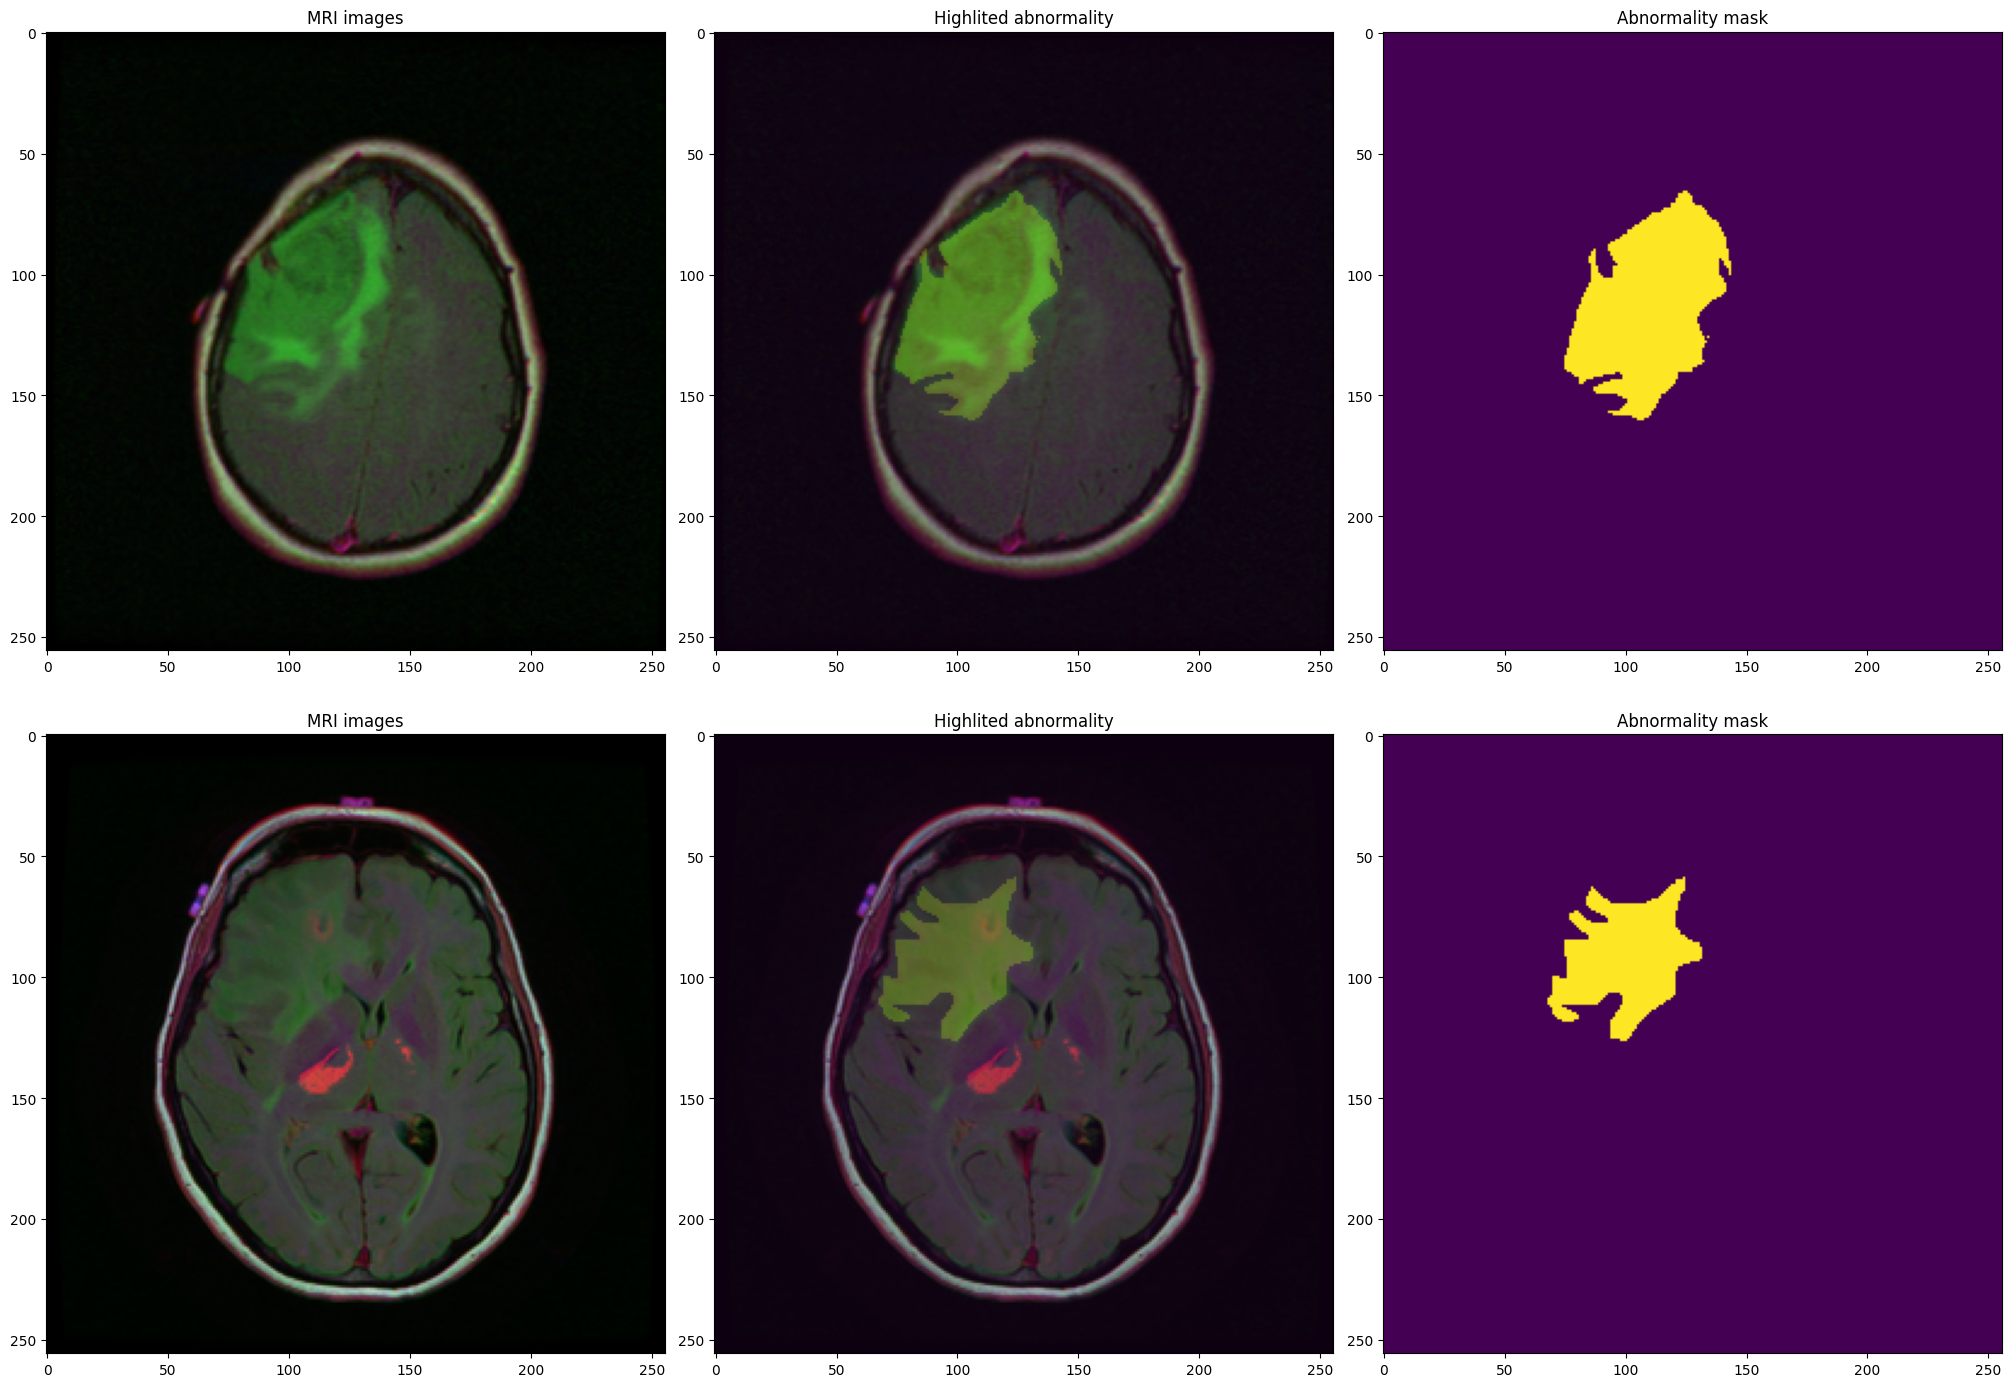

In [12]:
%matplotlib inline
n_examples = 2

fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
i = 0
for ax in axs:
    while True:
        image, mask = train_dataset.__getitem__(i, raw=True)
        i += 1
        if np.any(mask): 
            ax[0].set_title("MRI images")
            ax[0].imshow(image)
            ax[1].set_title("Highlited abnormality")
            ax[1].imshow(image)
            ax[1].imshow(mask, alpha=0.2)
            ax[2].imshow(mask)
            ax[2].set_title("Abnormality mask")
            break

## Unet Architecture

In [13]:
from torch.nn.functional import relu

In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, 
        # with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(self.n_channels, 64, kernel_size=3, padding='same') # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding='same') # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding='same') # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding='same') # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding='same') # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding='same') # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding='same') # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding='same') # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding='same') # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding='same') # output: 28x28x1024

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # output: 56x56x512
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding='same') # output: 54x54x512
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding='same') # output: 52x52x512

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # output: 104x104x256
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding='same') # output: 102x102x256
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding='same') # output: 100x100x256

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # output: 200x200x128
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding='same') # output: 198x198x128
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding='same') # output: 196x196x128

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # output: 392x392x64
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding='same') # output: 390x390x64
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding='same') # output: 388x388x64

        # Output layer
        self.outconv = nn.Conv2d(64, n_classes, kernel_size=1) # output: 388x388xn_classes

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)

        # concatenation of the feature maps from the encoder and the decoder
        xu11 = self.concat(xu1, xe42)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = self.concat(xu2, xe32)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = self.concat(xu3, xe22)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = self.concat(xu4, xe12)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out
    
    def concat(self, x1, x2):
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x

In [15]:
dir_checkpoint = Path('./checkpoints/')

In [16]:
import logging
import wandb
from torch import optim
from dice_score import dice_loss
from evaluate import evaluate

# Train

In [ ]:
def train(
        model,
        train_loader : DataLoader,
        val_loader : DataLoader,
        device,
        epochs: int = 5,
        batch_size: int = 16,
        learning_rate: float = 1e-6,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 1,
        amp: bool = True,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):

    n_train = len(train_loader.dataset)
    n_val = len(val_loader.dataset)

    # (Initialize logging)
    experiment = wandb.init(project='U-Net_MRI', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.amp.GradScaler(enabled=amp)
    criterion = nn.BCEWithLogitsLoss()
    global_step = 0

    print('begin training')
    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last, non_blocking=True)
                true_masks = true_masks.to(device=device, dtype=torch.long, non_blocking=True)

                with torch.autocast(device.type if device.type == 'cuda' else 'cpu', enabled=amp):
                    masks_pred = model(images)

                    loss = criterion(masks_pred.squeeze(1), true_masks.float())

                    loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
 

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))

                        experiment.log({
                            'learning rate': optimizer.param_groups[0]['lr'],
                            'validation Dice score': val_score,
                            'images': wandb.Image(images[0].cpu()),
                            'masks': {
                                'true': wandb.Image(true_masks[0].float().cpu()),
                                'pred': wandb.Image(((torch.sigmoid(masks_pred[0].squeeze(0)) > 0.5).float().cpu().numpy() * 255).astype(np.uint8)),
                            },
                            'step': global_step,
                            'epoch': epoch,
                            **histograms
                        })


                        # Save checkpoint only if the validation score is greater than the previous one
                        if save_checkpoint and (epoch == 1 or val_score > max(val_score_list)):
                            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
                            state_dict = model.state_dict()
                            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
                            logging.info(f'Checkpoint {epoch} saved!')


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=1)
model = model.to(memory_format=torch.channels_last)
model.to(device=device)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1

# GridSearch for optimal parameters

In [19]:
# gridsearch
import itertools

learning_rates = [1e-5, 1e-6, 1e-7, 1e-8]
momentums = [0.9, 0.99, 0.999]
weight_decays = [1e-6, 1e-7, 1e-8]
gradient_clippings = [0.5, 1.0, 1.5]

In [20]:
# # Create a list of all possible combinations of hyperparameters
# hyperparameter_grid = list(itertools.product(learning_rates, momentums, weight_decays, gradient_clippings))


# # Iterate over the hyperparameter grid
# for lr, momentum, weight_decay, grad_clip in hyperparameter_grid:
#     print(f'Training with lr={lr}, momentum={momentum}, weight_decay={weight_decay}, grad_clip={grad_clip}')
    
    
#     # Train the model with the current set of hyperparameters
#     train(model, train_loader, valid_loader, device, epochs=5, batch_size=64, learning_rate=lr, 
#           weight_decay=weight_decay, momentum=momentum, gradient_clipping=grad_clip)
    

In [25]:
#Training with lr=1e-05, momentum=0.9, weight_decay=1e-08, grad_clip=1.5
train(model, train_loader, valid_loader, device, epochs=20, batch_size=48, learning_rate=1e-05, 
          weight_decay=1e-08, momentum=0.9, gradient_clipping=1.0)

begin training


Epoch 20/20: 100%|██████████| 2750/2750 [00:29<00:00, 93.52img/s, loss (batch)=0.278] 


# IOU Score over test set

In [42]:
def iou_score(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=2).sum(dim=1)
    union = (pred + target).sum(dim=2).sum(dim=1) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.mean()

model.eval()
iou_scores = []

with torch.no_grad():
    for image, mask in test_loader:
        image = image.to(device)
        mask = mask.to(device)
        
        pred_mask = model(image)
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask = (pred_mask > threshold).float()
        
        iou = iou_score(pred_mask, mask)
        iou_scores.append(iou.item())

average_iou_score = np.mean(iou_scores)
print(f'Average IoU Score: {average_iou_score}')

Average IoU Score: 0.9499261840907011


# Test Set Visualizaton

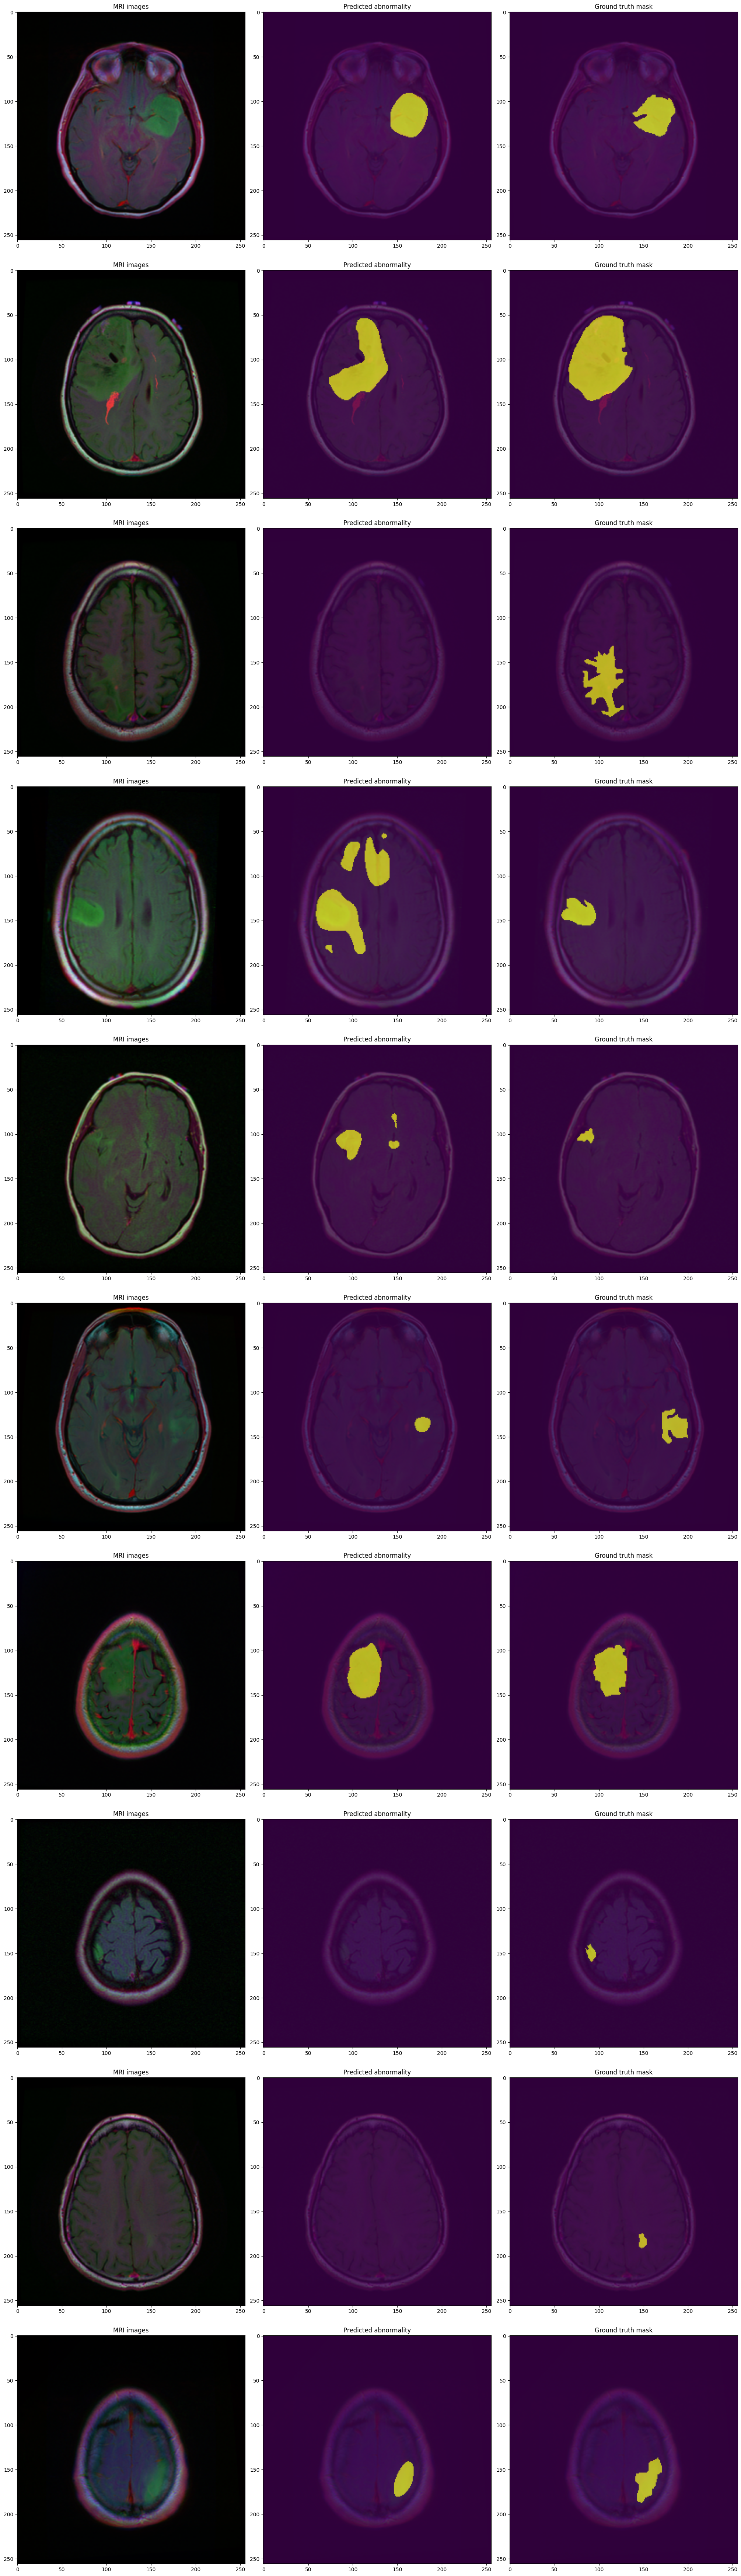

In [46]:
model.eval()
n_examples = 10
threshold = 0.7

fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
i = 20
for ax in axs:
    while True:
        image, mask = test_dataset.__getitem__(i, raw=True)
        img_tensor = transforms.functional.to_tensor(image).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_mask = model(img_tensor).squeeze().cpu().numpy()
            pred_mask = (pred_mask > threshold).astype(np.uint8)
        i += 1
        if np.any(mask): 
            ax[0].set_title("MRI images")
            ax[0].imshow(image)
            ax[1].set_title("Predicted abnormality")
            ax[1].imshow(image)
            ax[1].imshow(pred_mask, alpha = 0.7)
            ax[2].imshow(image)
            ax[2].imshow(mask, alpha = 0.7)
            ax[2].set_title("Ground truth mask")
            break
plt.show()

In [1]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

20